<a href="https://colab.research.google.com/github/MLMario/mariogj1987/blob/main/Simulation_Interaction_Effects_in_a_Ridesharing_Company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Interaction effects in a Marketplace Setting - A simplified Uber Example

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings

warnings.filterwarnings('ignore')




### Simulating Data with Interaction Effects
We will generate a dataset based on a simulation of data obtained during an A/A test, followed by an A/B price drop test for a ride-sharing company named "RideSharer."

In this data set, during the A/B test, we will introduce a network effect, commonly referred to as an interaction effect. We will assume that the treatment group receives a 20% average demand boost due to a 10% decrease in price. However, this increased demand in the treatment group will lead them to occupy more of the supply. As a result, the control group will have fewer available drivers, leading to fewer trips.

Here is a summary of the plan for the simulation:

**Data Structure**: The data will be structured by City - Day - Time Bucket (15 min intervals).

**Time Frame:** The simulation will span 28 days. The first 14 days will be an A/A test, and the subsequent 14 days will be the A/B test.

**City Names:** We will generate 150 random city names.

**Time Buckets:** Trips will be scaled randomly based on the time of the day to simulate peak demand hours.

**Trips:** We'll use normal distributions to simulate the average number of trips for each city. This number will be adjusted based on the time of day to simulate peak and off-peak hours.

**Price:** The average price will be based on the average number of trips for each city. Cities with more trips will generally have higher prices. For instance, New York might be more expensive than Missouri. It's important to note that we won't make prices and trip amounts interdependent, which means that prices will not increase during peak demand, for simplicity.

**A/A Test:** For the first 14 days, data for each time bucket will be divided into two groups: control_a_test and treatment_a_test, with similar values.

**A/B Test:**

For the next 14 days:

- In the treatment group, prices will decrease by 10%, resulting in a 20% increase in trips.
- In the control group, trips will decrease by a factor between 0.4 and 0.8 of the increase observed in the treatment group due to the reduced availability of drivers.

Let's begin by generating the data according to the plan outlined above.

In [37]:
def get_time_factor(bucket):
    if 0 <= bucket <= 16:  # 12-4 AM
        return np.random.uniform(0.55, 0.65)

    elif 16 <= bucket <= 28:  # 4-7 AM
        return np.random.uniform(0.75, 0.85)

    elif 28 <= bucket <= 36:  # 7-9 AM
        return np.random.uniform(1.3, 1.4)

    elif 36 <= bucket <= 48:  # 9-12 PM
        return np.random.uniform(0.85, 0.95)

    elif 48 <= bucket <= 68:  # 12-5 PM
        return np.random.uniform(0.95, 1.05)

    elif 68 <= bucket <= 80:  # 5-8 PM
        return np.random.uniform(1.5, 1.6)

    else:  # 8-12 PM
        return np.random.uniform(0.75, 0.85)

In [4]:
def produce_dataset(NUM_CITIES,NUM_DAYS,TIME_BUCKETS,START_DATE,EXPERIMENT_LIFT):

  #generating city names (City_1, City_2, etc...)
  cities = ["City_" + str(i) for i in range(1,NUM_CITIES+1)]

  # Generate base trips and prices for each city using normal distribution
  np.random.seed(0)
  base_trips = np.random.normal(5000, 750, NUM_CITIES).astype(int)
  base_prices = base_trips * 0.0025 + np.random.normal(0, 2, NUM_CITIES)

  df_list = []
  for day in range(NUM_DAYS):

      for bucket in range(TIME_BUCKETS):
          time_factor = get_time_factor(bucket)

          for city, trips, price in zip(cities, base_trips, base_prices):

              # calculating trips and price plus a random, time independent factor to add variability to the constant trend
              trips_control = int(trips * time_factor * np.random.normal(1, 0.15))
              price_control = round(price * np.random.normal(1, 0.05),2)

              trips_treatment = int(trips * time_factor * np.random.normal(1, 0.15))
              price_treatment = round(price * np.random.normal(1, 0.05),2)

              # Experiment logic
              if day < 14:  # A/A test
                  df_list.append([city, START_DATE + timedelta(days=day), bucket, 'control_a_test', trips_control, price_control])
                  df_list.append([city, START_DATE + timedelta(days=day), bucket, 'treatment_a_test', trips_treatment, price_treatment])

              else:  # A/B test with interaction effects

                  treatment_effect = np.random.normal((1+EXPERIMENT_LIFT), 0.03)
                  t_price = price_treatment * 0.9
                  t_trips = int(trips_treatment * treatment_effect)

                  # Key Network effect (Interaction Effect)
                  control_reduction = np.random.uniform(0.4, 0.8) * (t_trips - trips_treatment)
                  c_trips = int(trips - control_reduction)

                  df_list.append([city, START_DATE + timedelta(days=day), bucket, "control", c_trips, price_control])
                  df_list.append([city, START_DATE + timedelta(days=day), bucket, "treatment", t_trips, t_price])

  df_trips = pd.DataFrame(df_list, columns=["City", "Date", "15_min_time_period_bucket", "Experiment", "total_completed_trips", "average_price"])

  return df_trips







In [5]:
# Constants
NUM_CITIES = 150
NUM_DAYS = 28
TIME_BUCKETS = 96  # 24 hours * 4 (15-min buckets)
START_DATE = datetime(2023, 1, 1)
EXPERIMENT_LIFT = 0.2

df_trips = produce_dataset(NUM_CITIES,NUM_DAYS,TIME_BUCKETS,START_DATE,EXPERIMENT_LIFT )

### Validating simulation logic with the A/A test

**One of the reasons I'm adding an A/A test in the dataset is to test if my simulation has any potential logical errors. I'll make a few sanity checks:**

1) Over time buckets, price should be random and trips should follow the stablished price levels in the get_time_factor function

2) Trips should have a stable trend with a step jump when A/B test starts

3) Price should have a stable trend with a step down when A/B test starts

In [6]:
df_trips.sort_values(['City','Date', '15_min_time_period_bucket']).head(5)


,City,Date,15_min_time_period_bucket,Experiment,total_completed_trips,average_price
0,City_1,2023-01-01,0,control_a_test,3503,15.55
1,City_1,2023-01-01,0,treatment_a_test,2960,15.28
300,City_1,2023-01-01,1,control_a_test,4244,16.71
301,City_1,2023-01-01,1,treatment_a_test,3255,14.57
600,City_1,2023-01-01,2,control_a_test,4226,16.39


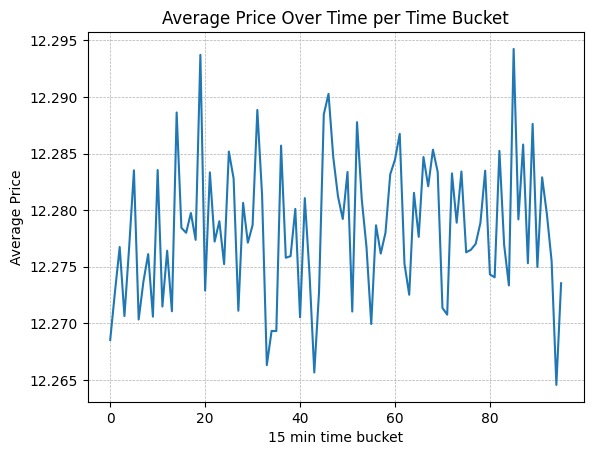

<Figure size 300x200 with 0 Axes>

In [7]:
df_trips.groupby(['15_min_time_period_bucket']).mean().reset_index()['average_price'].plot()

plt.xlabel('15 min time bucket')
plt.ylabel('Average Price')
plt.title('Average Price Over Time per Time Bucket')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.figure(figsize=(3, 2))
plt.tight_layout()
plt.show()



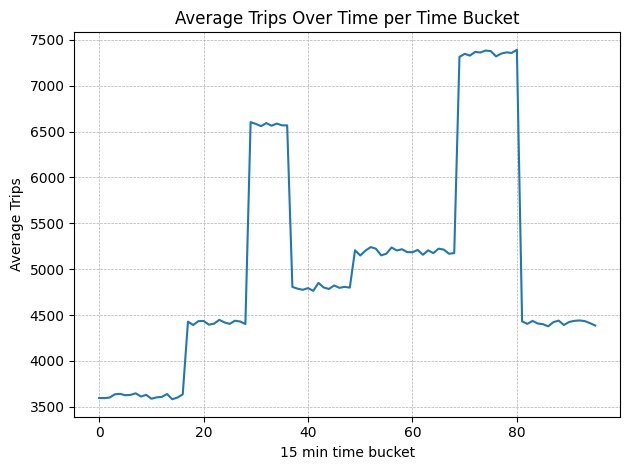

In [8]:
df_trips.groupby(['15_min_time_period_bucket']).mean().reset_index()['total_completed_trips'].plot()

plt.xlabel('15 min time bucket')
plt.ylabel('Average Trips')
plt.title('Average Trips Over Time per Time Bucket')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

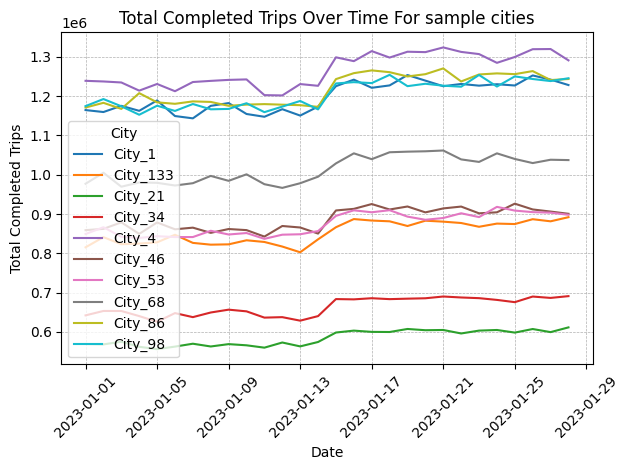

In [9]:
sample_cities = df_trips['City'].sample(10).unique() #ideally we want to do np.random.choice

sample_data = df_trips[df_trips['City'].isin(sample_cities)]

sample_data = sample_data.groupby(['Date','City']).sum().reset_index()

sns.lineplot(x="Date", y="total_completed_trips", hue="City", data=sample_data)

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Total Completed Trips')
plt.title('Total Completed Trips Over Time For sample cities')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



Now lets do some statistics on the A/A set and make sure trips and prices lookg similar enough in avg, median,  sd and distribution

In [10]:
# Separate df_trips into A/A data and A/B test data
aa_test_data = df_trips[df_trips['Experiment'].isin(['control_a_test','treatment_a_test'])]
ab_test_data = df_trips[df_trips['Experiment'].isin(['control','treatment'])]

In [11]:
aa_test_data.groupby('Experiment')[['total_completed_trips','average_price']].describe().round(1)

total_completed_trips                                  \
                                 count    mean     std     min     25%   
Experiment                                                               
control_a_test                201600.0  4880.5  1863.8  1098.0  3540.0   
treatment_a_test              201600.0  4878.4  1862.3  1033.0  3536.0   

                                          average_price                        \
                     50%     75%      max         count  mean  std  min   25%   
Experiment                                                                      
control_a_test    4499.0  5814.0  15454.0      201600.0  12.6  2.8  3.6  10.6   
treatment_a_test  4498.0  5813.0  15936.0      201600.0  12.6  2.8  3.6  10.6   

                                    
                   50%   75%   max  
Experiment                          
control_a_test    12.4  14.6  22.1  
treatment_a_test  12.4  14.6  22.2

- Some simple hypothesis testing (T-test) on the A/A sample to validate random distributions

In [12]:
from scipy.stats import ttest_ind

# Performing t-tests for the new dataset

trip_t_stat, trip_p_value = ttest_ind(
    aa_test_data[aa_test_data["Experiment"] == "control_a_test"]["total_completed_trips"],
    aa_test_data[aa_test_data["Experiment"] == "treatment_a_test"]["total_completed_trips"],
    equal_var=False
)

price_t_stat, price_p_value = ttest_ind(
    aa_test_data[aa_test_data["Experiment"] == "control_a_test"]["average_price"],
    aa_test_data[aa_test_data["Experiment"] == "treatment_a_test"]["average_price"],
    equal_var=False
)


print(f"NUll Hypotehsis (No difference in Trips) P-Value:{round(trip_p_value,2)}")

print(f"Null Hypothesis (No difference in Prices) P-Value:{round(price_p_value,2)}" )


NUll Hypotehsis (No difference in Trips) P-Value:0.72
Null Hypothesis (No difference in Prices) P-Value:0.82


So we fail to reject the null hypothesis by a large margin, **suggesting the A/A test was done correctly.**

### Showing how can network effects create bias in a simple T-test

- I already mention that the problem is that the control group is not independent from the treatment. In this case the treatment effect is decreasing the amount of completed trips in the control group, so when we compare the avg trips in the control vs avg trips in the treatment, the overall estimate lift will be higher!.

- **this bias can go both ways**. It can decrease or increase the calculated lift, even making it negative if in reality is positive, or making it positive if in reality is negative! This could lead to wrong product launch / changes decisions.

- This time we will approach the treatment effect calculations via a regression approach, since we are not including co-founders this is equivalent to a t-test

In [13]:
# Create binary indicator for treatment group

ab_test_data["Treatment_Indicator"] = (ab_test_data["Experiment"] == "treatment").astype(int)


In [14]:
# Regression for total completed trips
X = sm.add_constant(ab_test_data["Treatment_Indicator"])  # adding a constant (intercept)
y = ab_test_data["total_completed_trips"]

model_trips = sm.OLS(y, X).fit()

# Extracting coefficient (lift) and confidence interval for the treatment effect
trip_lift_regression = model_trips.params["Treatment_Indicator"]
trip_lift_ci_regression = model_trips.conf_int().loc["Treatment_Indicator"].values

# Regression for average price
y_price = ab_test_data["average_price"]

model_price = sm.OLS(y_price, X).fit()

# Extracting coefficient (lift) and confidence interval for the treatment effect
price_lift_regression = model_price.params["Treatment_Indicator"]
price_lift_ci_regression = model_price.conf_int().loc["Treatment_Indicator"].values







In [15]:
print(f"Price Average $ Lift: {price_lift_regression: .2f}")
print(f"Price Average $ confidence Interval: {np.around(price_lift_ci_regression,2)}")

print(f"Trips Average Lift: {trip_lift_regression: .0f}")
print(f"Trips Average Confidence Interval: {np.around(trip_lift_ci_regression,0)}")

Price Average $ Lift: -1.26
Price Average $ confidence Interval: [-1.27 -1.24]
Trips Average Lift:  1358
Trips Average Confidence Interval: [1348. 1368.]


In [16]:
# Average number of trips in the control group
avg_trips_control = ab_test_data[ab_test_data["Experiment"] == "control"]["total_completed_trips"].mean()
avg_price_control = ab_test_data[ab_test_data["Experiment"] == "control"]["average_price"].mean()

# Calculate the percentage increase
trip_percentage_increase = (trip_lift_regression / avg_trips_control) * 100
price_percentage_increase = (price_lift_regression/avg_price_control) * 100


print(f"Trips Average % Lift: {round(trip_percentage_increase,1)}%")
print(f"Price % Lift: {round(price_percentage_increase,1)}%")


Trips Average % Lift: 30.1%
Price % Lift: -10.0%


**The estimated lift is 30%, way above the 20% we simulated. This makes sense, since the treatment lift decreased the control trips, increasing the distance between the average treatment and control groups**

# What can we do now?

After you've conducted the A/A test followed by the A/B test, you might be concerned about the network effect and want to validate whether the observed lift is real. The major challenge is that the interaction effect makes it difficult to measure the real impact of the price drop.

There are a couple of methods we can use to validate the lift:

1. Randomizing the A/B test at the market level (city level in this case) is a solid approach. It ensures that the demand in one city doesn't affect the supply of another city. However, there is a risk of running into sample size problems. Techniques like synthetic controls with difference-in-differences analysis or using random and fixed-effect models to analyze data at the customer level when randomized at the market level might be suitable.

2. Another method is the switchback experiment, where time buckets within cities are randomized. This approach has its challenges, especially concerning autocorrelation or carry-over effects.

If you're interested in discussing these methods further, feel free to contact me at mariogj1987@gmail.com. I'm also planning to write some articles about these methods.

But, for the sake of argument, let's assume there was an oversight, and before notifying the Product Manager, you'd like to determine if there's a good chance that the observed lift is at least directionally correct. Perhaps this preliminary insight will suffice, and we can avoid unnecessary resource expenditure.

A simple approach to address this is to try to predict the counterfactual. Depending on your data, there are various methods to achieve this. Given that our data is aggregated by city with a stable trend and variance, a robust prediction seems pausible using straightforward time series prediction.

**Note:** For simplicity, I'm not splitting the time series data into training and testing sets or undergoing an optimization process. In real-world scenarios, it's crucial to be rigorous with your methodologies. Im also simplifying by doing a day level prediction, but you might want to consider predicting at the same granularity of your data as long as that can improve the quality of your forecast.

In [22]:

# Separate control data for the first 14 days (training data)
train_data = df_trips[(df_trips["Date"] < START_DATE + timedelta(days=14)) & (df_trips["Experiment"] == "control_a_test")]
predictions = []

# For each city, train a Holt-Winters model and predict values for the last 14 days
for city in df_trips['City'].unique():
    city_train_data = train_data[train_data["City"] == city].groupby("Date")["total_completed_trips"].sum()

    # Training the model: No trend adn daily seasonality
    model = ExponentialSmoothing(city_train_data, trend=None, seasonal="add", seasonal_periods=None)
    model_fit = model.fit()

    # Predicting values for the last 14 days
    city_pred = model_fit.forecast(steps=14)

    for date, pred in zip(city_pred.index, city_pred.values):
       predictions.append([city, 'control', date, pred])

# Convert predictions and errors to DataFrames
predictions_df = pd.DataFrame(predictions, columns=['City','Experiment','Date',"Predicted_Trips"])

predictions_df.head()


,City,Experiment,Date,Predicted_Trips
0,City_1,control,2023-01-15,591270.560765
1,City_1,control,2023-01-16,590726.291575
2,City_1,control,2023-01-17,576963.273016
3,City_1,control,2023-01-18,575716.009550
4,City_1,control,2023-01-19,581474.024782


Let' check the prediction lines...

,City,Experiment,Date,total_completed_trips,Predicted_Trips,trips,is_predicted
0,City_1,control_a_test,2023-01-01,583083.0,NaN,583083.0,real
1,City_1,control_a_test,2023-01-02,575306.0,NaN,575306.0,real
2,City_1,control_a_test,2023-01-03,589794.0,NaN,589794.0,real
3,City_1,control_a_test,2023-01-04,585712.0,NaN,585712.0,real
4,City_1,control_a_test,2023-01-05,599675.0,NaN,599675.0,real


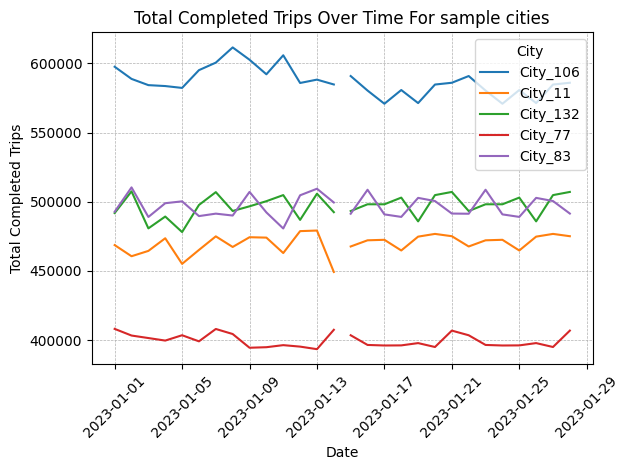

In [33]:
#pd.concat([train_data,predictions_df], axis = 0)
viz_data = pd.concat([
    train_data.groupby(['City','Experiment',"Date"])["total_completed_trips"].sum().reset_index(),
    predictions_df
    ], axis = 0)

unique_cities = viz_data['City'].unique()
sample_cities = np.random.choice(unique_cities, 5, replace=False)

sample_data = viz_data[viz_data['City'].isin(sample_cities)]

#viz_data['trips'] = viz_data['total_completed_trips'].fillna(0) + viz_data['Predicted_Trips'].fillna(0)

#viz_data['is_predicted'] = np.where(viz_data['total_completed_trips'].notnull(),'real',
#                                   np.where(viz_data['Predicted_Trips'].notnull(),'predicted',np.nan))

sns.lineplot(x="Date", y="total_completed_trips", hue="City", data=sample_data,legend = False)
sns.lineplot(x="Date", y="Predicted_Trips", hue="City", data=sample_data)

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Total Completed Trips')
plt.title('Total Completed Trips Over Time For sample cities')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


- These predictions appear reasonable. Let's compare the average number of trips in the control group from the predicted dataset with the average number of trips in the treatment group from the A/B dataset to determine the directinal lift.

In [35]:
#using the daily predictions to calculate the lift.
avg_daily_treatment = ab_test_data[ab_test_data["Experiment"] == "treatment"].groupby(['City','Date'])['total_completed_trips'].sum().mean()
avg_daily_control = predictions_df['Predicted_Trips'].mean()

lift_against_prediction = avg_daily_treatment / avg_daily_control - 1

print(f'Lift against adjusted control: {lift_against_prediction*100:.1f}%')





Lift against adjusted control: 20.0%


Our approximation closely matches the true lift in this scenario. In real-life situations, **using this method should be considered a last resort**. As mentioned earlier, we shouldn't find ourselves in a position where this becomes necessary. Even with an accurate counterfactual estimation, any confidence interval or hypothesis testing on such a prediction will likely be flawed if applied directly.



### Conclusions

Through our simulation and subsequent validation methods, we explored the complexities of analyzing the impact of a price drop in the presence of interaction effects. Our study underscores the importance of careful experimental design and the challenges posed by network effects. While the methods presented offer potential insights, they come with their caveats. It's imperative for analysts to adopt robust methodologies, be aware of potential pitfalls, and continuously validate results to draw accurate and actionable insights.

